In [1]:

import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from cryptovision.tools import (
    image_directory_to_pandas,
    split_image_dataframe,
    tf_dataset_from_pandas
)

from tensorflow.keras.applications import ResNet50V2, EfficientNetV2B0                                          # type: ignore
from tensorflow.keras.applications.resnet_v2 import preprocess_input as resnet_preprocess                       # type: ignore
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnet_preprocess           # type: ignore
from tensorflow.keras.layers import (                                                                           # type: ignore    
    Input, RandomFlip, RandomRotation, RandomZoom, 
    RandomTranslation, RandomContrast, RandomBrightness,
    GlobalAveragePooling2D, Dense, BatchNormalization, Activation,
    Concatenate, Dropout, LeakyReLU
) 

from cryptovision.model import *

# Enable mixed precision for Apple Silicon
tf.keras.mixed_precision.set_global_policy('mixed_float16')

2025-01-08 18:02:17.333 | INFO     | cryptovision.config:<module>:15 - PROJ_ROOT path is: /Users/leonardo/Documents/Projects/cryptovision


In [2]:
# Dataset
SETUP = {
    "class_samples_threshold": 99,
    "test_size": .15,
    "validation_size": .15,
    "batch_size": 128,
    
    # Training
    "image_shape": (384, 384, 3),
    "epochs": 10,
    "learning_rate": 1e-4,
    "loss_type": {
        "family": "categorical_focal_crossentropy",
        "genus": "categorical_focal_crossentropy",
        "species": "categorical_focal_crossentropy",
    },
    "metrics": {
        "family": ["accuracy", "AUC", "Precision", "Recall"],
        "genus": ["accuracy", "AUC", "Precision", "Recall"],
        "species": ["accuracy", "AUC", "Precision", "Recall"],
    },
    "early_stopping": {
        "monitor": "val_loss",
        "patience": 5,
        "restore_best_weights": True
    },
    "reduce_lr": {
        "monitor": "val_loss",
        "lr_factor": 0.5,
        "lr_patience": 3,
        "lr_min": 1e-6
    }
    
}


In [3]:
df_lab = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/fish_functions/Species_v03")
df_web = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/web/Species_v01")
df_inatlist = image_directory_to_pandas("/Users/leonardo/Library/CloudStorage/Box-Box/CryptoVision/Data/inaturalist/Species_v02")

df = pd.concat([df_lab, df_web, df_inatlist], ignore_index=True, axis=0)

# find in the species column the values with lass than 50 occurences
counts = df['species'].value_counts()
df = df[df['species'].isin(counts[counts > SETUP['class_samples_threshold']].index)]

train_df, val_df, test_df = split_image_dataframe(df, test_size=0.15, val_size=0.15, stratify_by='folder_label')

names = {
    'family': sorted(df['family'].unique()),
    'genus': sorted(df['genus'].unique()),
    'species': sorted(df['species'].unique()),
}

train_ds, _, _, _ = tf_dataset_from_pandas(train_df, batch_size=128, image_size=SETUP['image_shape'][:2])
val_ds, _, _, _ = tf_dataset_from_pandas(val_df, batch_size=128, image_size=SETUP['image_shape'][:2])
test_ds, _, _, _ = tf_dataset_from_pandas(test_df, batch_size=128, image_size=SETUP['image_shape'][:2])

AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

2025-01-08 18:02:17.908199: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2025-01-08 18:02:17.908226: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-01-08 18:02:17.908230: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-01-08 18:02:17.908242: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-01-08 18:02:17.908252: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
efnet = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=SETUP['image_shape'])
efnet.trainable = False

resnet = ResNet50V2(include_top=False, weights='imagenet', input_shape=SETUP['image_shape'])
resnet.trainable = False

augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(0.1, 0.1),
        RandomContrast(0.2),
        RandomBrightness(0.2),
    ],
    name='augmentation'
)

In [5]:
import wandb
from loguru import logger
from wandb.integration.keras import WandbMetricsLogger

wandb.require("core")

PROJ = "CryptoVision - AI Development"
NICKNAME = f"EFFV2B0_{SETUP['image_shape'][0]}_ATT_CONC_v12"


with wandb.init(project=PROJ, name=NICKNAME, config={**SETUP}) as run:
    
    model = model_attention(
        name=NICKNAME,
        labels=names,
        pretrain=efnet,
        preprocess= efficientnet_preprocess,
        augmentation=None,
        input_shape=SETUP['image_shape'],
    )
    
    logger.info(print(model.summary(show_trainable=True)))
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=SETUP["learning_rate"]),
        loss=SETUP['loss_type'],
        metrics=SETUP['metrics'],
        #loss_weights=SETUP["loss_weights"],
    )
    
    wandb_logger = WandbMetricsLogger()
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor=SETUP['early_stopping']["monitor"],
        patience=SETUP["early_stopping"]['patience'],
        restore_best_weights=SETUP['early_stopping']['restore_best_weights'],
    )
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=SETUP['reduce_lr']["monitor"],
        factor=SETUP['reduce_lr']["lr_factor"],
        patience=SETUP['reduce_lr']["lr_patience"],
        min_lr=SETUP['reduce_lr']["lr_min"],
    )
    
    checkpoint = tf.keras.callbacks.ModelCheckpoint(
        filepath=f"models/{NICKNAME}.keras",
        monitor="val_loss", 
        save_best_only=True,  
        mode="min",  
        verbose=0  
    )
    
    history = model.fit(
        train_ds,
        epochs=SETUP["epochs"],
        validation_data=val_ds,
        callbacks=[wandb_logger, early_stopping, reduce_lr, checkpoint, TQDMProgressBar()],
        verbose=0,
    )
    
    logger.success(f"Model {NICKNAME} trained and logged to wandb.")

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: leonardo-reginato (cryptovision). Use `wandb login --relogin` to force relogin


Model: "EFFV2B0_384_ATT_CONC_v12"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 384,     │         0 │ -              │   -   │
│ (InputLayer)      │ 384, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast_2 (Cast)     │ (None, 384,     │         0 │ input_layer[0… │   -   │
│                   │ 384, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ preprocess        │ (None, 384,     │         0 │ cast_2[0][0]   │   -   │
│ (Lambda)          │ 384, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ efficientnetv2-b0 │ (None, 12, 12,  │ 5,919,312 │ preprocess[0]… │   N   │
│ (Functional)      │ 1280)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ self_attention    │ (None, 12, 12,  │ 4,919,040 │ efficientnetv… │   Y   │
│ (SelfAttention)   │ 1280)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ GlobAvgPool2D     │ (None, 1280)    │         0 │ self_attentio… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ shared_layer      │ (None, 2048)    │ 2,623,488 │ GlobAvgPool2D… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 2048)    │     8,192 │ shared_layer[… │   Y   │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation        │ (None, 2048)    │         0 │ batch_normali… │   -   │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ family (Dense)    │ (None, 18)      │    36,882 │ activation[0]… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate       │ (None, 2066)    │         0 │ activation[0]… │   -   │
│ (Concatenate)     │                 │           │ family[0][0]   │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ genus (Dense)     │ (None, 43)      │    88,881 │ concatenate[0… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_1     │ (None, 2109)    │         0 │ activation[0]… │   -   │
│ (Concatenate)     │                 │           │ family[0][0],  │       │
│                   │                 │           │ genus[0][0]    │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ species (Dense)   │ (None, 61)      │   128,710 │ concatenate_1… │   Y   │
└───────────────────┴─────────────────┴───────────┴────────────────┴───────┘

 Total params: 13,724,505 (52.35 MB)

 Trainable params: 7,801,097 (29.76 MB)

 Non-trainable params: 5,923,408 (22.60 MB)

None
2025-01-08 18:02:24.986 | INFO     | __main__:<module>:22 - None


Epoch 1/10:   0%|          | 0/92 [00:00<?, ?batch/s]2025-01-08 18:02:28.634478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-01-08 18:02:44.092601: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 33 of 11722
2025-01-08 18:03:03.969994: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:5: Filling up shuffle buffer (this may take a while): 91 of 11722
2025-01-08 18:03:04.180682: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2025-01-08 18:03:04.183699: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
Epoch 1/10: 100%|██████████| 92/92 [05:21<00:00,  3.50s/batch, loss=0.8815, family_acc=0.7107, genus_acc=0.6400, species_acc=0.5671]


2025-01-08 18:07:46.856 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 1 completed - Loss: 0.8815, Val Family Accuracy: 0.8679, Val Genus Accuracy: 0.8456, Val Species Accuracy: 0.8062


Epoch 2/10: 100%|██████████| 92/92 [04:51<00:00,  3.17s/batch, loss=0.2110, family_acc=0.9072, genus_acc=0.8958, species_acc=0.8736]


2025-01-08 18:12:38.154 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 2 completed - Loss: 0.2110, Val Family Accuracy: 0.9081, Val Genus Accuracy: 0.9053, Val Species Accuracy: 0.8826


Epoch 3/10: 100%|██████████| 92/92 [04:40<00:00,  3.05s/batch, loss=0.1225, family_acc=0.9367, genus_acc=0.9342, species_acc=0.9213]


2025-01-08 18:17:19.205 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 3 completed - Loss: 0.1225, Val Family Accuracy: 0.9160, Val Genus Accuracy: 0.9160, Val Species Accuracy: 0.8957


Epoch 4/10: 100%|██████████| 92/92 [04:43<00:00,  3.08s/batch, loss=0.0814, family_acc=0.9552, genus_acc=0.9541, species_acc=0.9399]


2025-01-08 18:22:02.806 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 4 completed - Loss: 0.0814, Val Family Accuracy: 0.9296, Val Genus Accuracy: 0.9252, Val Species Accuracy: 0.9053


Epoch 5/10: 100%|██████████| 92/92 [04:59<00:00,  3.25s/batch, loss=0.0577, family_acc=0.9655, genus_acc=0.9660, species_acc=0.9587]


2025-01-08 18:27:01.998 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 5 completed - Loss: 0.0577, Val Family Accuracy: 0.9343, Val Genus Accuracy: 0.9316, Val Species Accuracy: 0.9101


Epoch 6/10: 100%|██████████| 92/92 [04:41<00:00,  3.06s/batch, loss=0.0423, family_acc=0.9718, genus_acc=0.9760, species_acc=0.9678]


2025-01-08 18:31:43.592 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 6 completed - Loss: 0.0423, Val Family Accuracy: 0.9339, Val Genus Accuracy: 0.9327, Val Species Accuracy: 0.9164


Epoch 7/10: 100%|██████████| 92/92 [04:28<00:00,  2.91s/batch, loss=0.0330, family_acc=0.9771, genus_acc=0.9821, species_acc=0.9753]


2025-01-08 18:36:11.749 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 7 completed - Loss: 0.0330, Val Family Accuracy: 0.9351, Val Genus Accuracy: 0.9304, Val Species Accuracy: 0.9168


Epoch 8/10: 100%|██████████| 92/92 [04:18<00:00,  2.81s/batch, loss=0.0256, family_acc=0.9810, genus_acc=0.9852, species_acc=0.9801]


2025-01-08 18:40:30.645 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 8 completed - Loss: 0.0256, Val Family Accuracy: 0.9320, Val Genus Accuracy: 0.9351, Val Species Accuracy: 0.9228


Epoch 9/10: 100%|██████████| 92/92 [04:21<00:00,  2.85s/batch, loss=0.0204, family_acc=0.9836, genus_acc=0.9879, species_acc=0.9830]


2025-01-08 18:44:52.625 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 9 completed - Loss: 0.0204, Val Family Accuracy: 0.9379, Val Genus Accuracy: 0.9375, Val Species Accuracy: 0.9220


Epoch 10/10: 100%|██████████| 92/92 [04:21<00:00,  2.84s/batch, loss=0.0178, family_acc=0.9852, genus_acc=0.9875, species_acc=0.9849]


2025-01-08 18:49:13.739 | INFO     | cryptovision.model:on_epoch_end:83 - Epoch 10 completed - Loss: 0.0178, Val Family Accuracy: 0.9403, Val Genus Accuracy: 0.9367, Val Species Accuracy: 0.9220
2025-01-08 18:49:13.888 | SUCCESS  | __main__:<module>:62 - Model EFFV2B0_384_ATT_CONC_v12 trained and logged to wandb.


epoch/epoch,▁▂▃▃▄▅▆▆▇█
epoch/family_AUC,▁▇████████
epoch/family_Precision,▁▅▆▇▇█████
epoch/family_Recall,▁▆▆▇▇█████
epoch/family_accuracy,▁▆▇▇▇█████
epoch/family_loss,█▃▂▂▁▁▁▁▁▁
epoch/genus_AUC,▁▇████████
epoch/genus_Precision,▁▆▆▇▇█████
epoch/genus_Recall,▁▅▆▇▇█████
epoch/genus_accuracy,▁▆▇▇██████
epoch/genus_loss,█▃▂▂▁▁▁▁▁▁


In [6]:
results = model.evaluate(test_ds, return_dict=True)

for k, v in results.items():
    print(f" Testing {k}: {v:.3f}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - family_AUC: 0.9980 - family_Precision: 0.9628 - family_Recall: 0.9273 - family_accuracy: 0.9457 - family_loss: 0.0253 - genus_AUC: 0.9967 - genus_Precision: 0.9704 - genus_Recall: 0.9139 - genus_accuracy: 0.9464 - genus_loss: 0.0335 - loss: 0.1025 - species_AUC: 0.9972 - species_Precision: 0.9637 - species_Recall: 0.8852 - species_accuracy: 0.9279 - species_loss: 0.0443
 Testing family_AUC: 0.998
 Testing family_Precision: 0.961
 Testing family_Recall: 0.926
 Testing family_accuracy: 0.943
 Testing family_loss: 0.024
 Testing genus_AUC: 0.998
 Testing genus_Precision: 0.970
 Testing genus_Recall: 0.916
 Testing genus_accuracy: 0.942
 Testing genus_loss: 0.032
 Testing loss: 0.098
 Testing species_AUC: 0.997
 Testing species_Precision: 0.964
 Testing species_Recall: 0.887
 Testing species_accuracy: 0.926
 Testing species_loss: 0.042


 Correct Prediction: Labridae Gomphosus varius 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


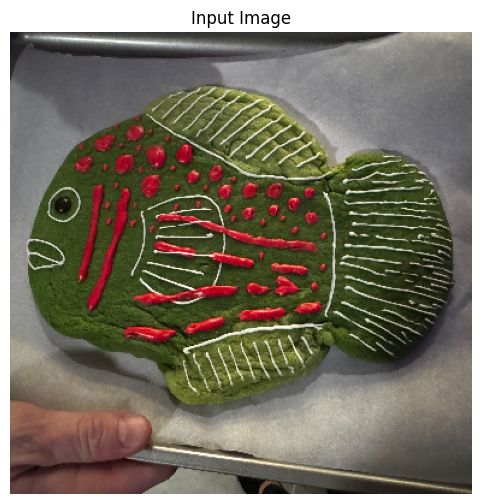

Top 3 Family Predictions:
Gobiidae: 0.4824
Pomacanthidae: 0.2004
Cirrhitidae: 0.1381
Pseudochromidae: 0.0347
Scorpaenidae: 0.0334

Top 3 Genus Predictions:
Gobiodon: 0.5557
Koumansetta: 0.2056
Pomacanthus: 0.0431
Labroides: 0.0429
Trimma: 0.0281

Top 3 Species Predictions:
Gobiodon histrio: 0.6782
Pomacanthus maculosus: 0.1057
Trimma macrophthalmus: 0.0447
Labroides dimidiatus: 0.0408
Koumansetta rainfordi: 0.0158


In [43]:
def predict_image(image_path, model, family_labels, genus_labels, species_labels, image_size=(224,224) ,top_k=3):
    """
    Predict the top-k family, genus, and species from an image using a trained model,
    and display the image with predictions.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - family_labels (list): List of family labels.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_family: List of tuples (family, confidence) for top k family predictions.
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, image_size)
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict family, genus, and species
    family_pred, genus_preds, species_preds = model.predict(img)
    
    # Get top-k predictions for family
    top_k_family_indices = np.argsort(family_pred[0])[-top_k:][::-1]
    top_k_family = [(family_labels[i], family_pred[0][i]) for i in top_k_family_indices]

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [(species_labels[i], species_preds[0][i]) for i in top_k_species_indices]

    # Display the image
    plt.figure(figsize=(6, 6))
    plt.imshow(tf.image.resize(img[0], image_size) / 255.0)
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    # Print top-k predictions for each level
    print("Top 3 Family Predictions:")
    for family, confidence in top_k_family:
        print(f"{family}: {confidence:.4f}")

    print("\nTop 3 Genus Predictions:")
    for genus, confidence in top_k_genus:
        print(f"{genus}: {confidence:.4f}")

    print("\nTop 3 Species Predictions:")
    for species, confidence in top_k_species:
        print(f"{species}: {confidence:.4f}")

    return top_k_family, top_k_genus, top_k_species

idx = np.random.randint(0, test_df.shape[0])

image_path = test_df['image_path'].values[idx]

image_path = '/Users/leonardo/Desktop/Screenshot 2025-01-08 at 7.37.07 PM.png'

print(f" Correct Prediction: {test_df['family'].values[idx]} {test_df['species'].values[idx]} \n")

top_k_family, top_k_genus, top_k_species = predict_image(
    image_path, model, names['family'], names['genus'], names['species'], top_k=5, image_size=(384, 384)
)


### Old

In [15]:
pretrain = EfficientNetV2B0(include_top=False, weights='imagenet', input_shape=image_shape)
pretrain.trainable = False

inputs = Input(shape=image_shape, name='input')
x = efficientnet_preprocess(inputs)
x = pretrain(x, training=False)

features = GlobalAveragePooling2D()(x)

shared_layer = Dense(2048,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(shared_layer)

# Species Output
species_output = Dense(len(names['species']), activation='softmax', name='species')(shared_layer)

model_eff = tf.keras.Model(
    inputs, 
    [family_output, genus_output, species_output],
    name = "EfficientNetWithSharedSimple"
)

model_eff.summary()

Model: "EfficientNetWithSharedSimple"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 348, 348,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 11, 11,    │  5,919,312 │ input[0][0]       │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-b… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 2048)      │  2,623,488 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 2048)      │      8,192 │ shared_layer[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 2048)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │     36,882 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 43)        │     88,107 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 61)        │    124,989 │ activation_4[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 8,800,970 (33.57 MB)

 Trainable params: 2,877,562 (10.98 MB)

 Non-trainable params: 5,923,408 (22.60 MB)

In [17]:
from cryptovision.model import TQDMProgressBar
import datetime

# Define TensorBoard log directory
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

model_eff.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics = {
        'family': ["accuracy", ],
        'genus': ["accuracy", ],
        'species': ["accuracy", ],
    },
)

history = model_eff.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - family_accuracy: 0.4745 - family_loss: 0.3568 - genus_accuracy: 0.3430 - genus_loss: 0.6121 - loss: 1.6980 - species_accuracy: 0.2889 - species_loss: 0.7281 - val_family_accuracy: 0.8118 - val_family_loss: 0.2697 - val_genus_accuracy: 0.7839 - val_genus_loss: 0.4618 - val_loss: 1.3086 - val_species_accuracy: 0.7513 - val_species_loss: 0.5767
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - family_accuracy: 0.8624 - family_loss: 0.0704 - genus_accuracy: 0.8348 - genus_loss: 0.1216 - loss: 0.3635 - species_accuracy: 0.7890 - species_loss: 0.1713 - val_family_accuracy: 0.8822 - val_family_loss: 0.1264 - val_genus_accuracy: 0.8747 - val_genus_loss: 0.2270 - val_loss: 0.6542 - val_species_accuracy: 0.8392 - val_species_loss: 0.3005
Epoch 3/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - family_accuracy: 0.9041 - family_loss: 0.0449 - genus_accuracy: 0.8952 - genus_loss: 0.0695 - loss: 0.2090 - species_accuracy: 0.8738 - species_loss: 0.0

In [18]:
results = model_eff.evaluate(test_ds, return_dict=True)

20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 1s/step - family_accuracy: 0.9368 - family_loss: 0.0263 - genus_accuracy: 0.9222 - genus_loss: 0.0409 - loss: 0.1167 - species_accuracy: 0.9181 - species_loss: 0.0499


In [21]:
for k, v in results.items():
    print(f" Testing {k}: {v:.3f}")

 Testing family_accuracy: 0.939
 Testing family_loss: 0.027
 Testing genus_accuracy: 0.925
 Testing genus_loss: 0.041
 Testing loss: 0.117
 Testing species_accuracy: 0.917
 Testing species_loss: 0.050


In [25]:
# Reproduction phorcys_v09

pretrain = ResNet50V2(include_top=False, weights='imagenet', input_shape=image_shape)
pretrain.trainable = False

augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.2),
        RandomZoom(0.2),
        RandomTranslation(0.1, 0.1),
        RandomContrast(0.2),
        RandomBrightness(0.2),
    ],
    name='data_augmentation'
)

inputs = Input(shape=image_shape, name='input')
x = augmentation(inputs)
x = resnet_preprocess(x)
x = pretrain(x, training=False)
features = GlobalAveragePooling2D()(x)

shared_layer = Dense(512,name='shared_layer')(features)
shared_layer = BatchNormalization()(shared_layer)
shared_layer = Activation('relu')(shared_layer)
shared_layer = Dropout(0.3)(shared_layer)

# Family Output
family_output = Dense(len(names['family']), activation='softmax', name='family')(shared_layer)

# Genus Output
genus_features = Concatenate()([shared_layer, family_output])
genus_hidden = Dense(256, activation='relu')(genus_features)
genus_output = Dense(len(names['genus']), activation='softmax', name='genus')(genus_hidden)

# Species Output
species_features = Concatenate()([shared_layer, family_output, genus_output])
species_hidden = Dense(256, activation='relu')(species_features)
species_output = Dense(len(names['species']), activation='softmax', name='species')(species_hidden)

model = tf.keras.Model(
    inputs, 
    [family_output, genus_output, species_output],
    name = "PhorcysV9"
)

model.summary()

Model: "PhorcysV9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input (InputLayer)  │ (None, 348, 348,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cast_10 (Cast)      │ (None, 348, 348,  │          0 │ input[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ data_augmentation   │ (None, 348, 348,  │          0 │ cast_10[0][0]     │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ true_divide_2       │ (None, 348, 348,  │          0 │ data_augmentatio… │
│ (TrueDivide)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract_2          │ (None, 348, 348,  │          0 │ true_divide_2[0]… │
│ (Subtract)          │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50v2          │ (None, 11, 11,    │ 23,564,800 │ subtract_2[0][0]  │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 2048)      │          0 │ resnet50v2[0][0]  │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_layer        │ (None, 512)       │  1,049,088 │ global_average_p… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ shared_layer[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_7        │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 512)       │          0 │ activation_7[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ family (Dense)      │ (None, 18)        │      9,234 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 530)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ family[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 256)       │    135,936 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 43)        │     11,051 │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 573)       │          0 │ dropout_2[0][0],  │
│ (Concatenate)       │                   │            │ family[0][0],     │
│                     │                   │            │ genus[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 256)       │    146,944 │ concatenate_4[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 61)        │     15,677 │ dense_4[0][0]     │
└─────────────────────┴───────────────────┴────────────┴─────────────────

 Total params: 24,934,778 (95.12 MB)

 Trainable params: 1,368,954 (5.22 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

In [26]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss = 'categorical_focal_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
    loss_weights={
        "family": 1.0,
        "genus": 1.5,
        "species": 2.0,
    }
)

history_phorcys = model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10,
    verbose = 1,
)

Epoch 1/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 217s 2s/step - family_AUC: 0.5811 - family_Precision: 0.3944 - family_Recall: 0.0266 - family_accuracy: 0.1473 - family_loss: 0.7071 - genus_AUC: 0.6374 - genus_Precision: 0.4784 - genus_Recall: 0.0083 - genus_accuracy: 0.1172 - genus_loss: 1.2813 - loss: 3.9124 - species_AUC: 0.6188 - species_Precision: 0.4756 - species_Recall: 0.0015 - species_accuracy: 0.0877 - species_loss: 1.9234 - val_family_AUC: 0.9324 - val_family_Precision: 0.9415 - val_family_Recall: 0.0704 - val_family_accuracy: 0.5798 - val_family_loss: 0.3101 - val_genus_AUC: 0.8982 - val_genus_Precision: 0.8500 - val_genus_Recall: 0.0068 - val_genus_accuracy: 0.4644 - val_genus_loss: 0.8419 - val_loss: 2.5535 - val_species_AUC: 0.8780 - val_species_Precision: 1.0000 - val_species_Recall: 0.0040 - val_species_accuracy: 0.3800 - val_species_loss: 1.4004
Epoch 2/10
92/92 ━━━━━━━━━━━━━━━━━━━━ 197s 2s/step - family_AUC: 0.9266 - family_Precision: 0.8476 - family_Recall: 0.2778 - family_acc

In [27]:
results_phorcys = model.evaluate(test_ds, return_dict=True)


20/20 ━━━━━━━━━━━━━━━━━━━━ 32s 2s/step - family_AUC: 0.9932 - family_Precision: 0.9345 - family_Recall: 0.7632 - family_accuracy: 0.8661 - family_loss: 0.0640 - genus_AUC: 0.9947 - genus_Precision: 0.9422 - genus_Recall: 0.7705 - genus_accuracy: 0.8675 - genus_loss: 0.1195 - loss: 0.3841 - species_AUC: 0.9943 - species_Precision: 0.9268 - species_Recall: 0.7044 - species_accuracy: 0.8338 - species_loss: 0.2036
 Testing family_accuracy: 0.939
 Testing family_loss: 0.027
 Testing genus_accuracy: 0.925
 Testing genus_loss: 0.041
 Testing loss: 0.117
 Testing species_accuracy: 0.917
 Testing species_loss: 0.050


In [28]:

for k, v in results_phorcys.items():
    print(f" Testing {k}: {v:.3f}")

 Testing family_AUC: 0.994
 Testing family_Precision: 0.940
 Testing family_Recall: 0.778
 Testing family_accuracy: 0.875
 Testing family_loss: 0.061
 Testing genus_AUC: 0.994
 Testing genus_Precision: 0.949
 Testing genus_Recall: 0.778
 Testing genus_accuracy: 0.865
 Testing genus_loss: 0.120
 Testing loss: 0.380
 Testing species_AUC: 0.995
 Testing species_Precision: 0.933
 Testing species_Recall: 0.719
 Testing species_accuracy: 0.835
 Testing species_loss: 0.201


In [29]:
model.summary(show_trainable=True)

Model: "PhorcysV9"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input             │ (None, 348,     │         0 │ -              │   -   │
│ (InputLayer)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast_10 (Cast)    │ (None, 348,     │         0 │ input[0][0]    │   -   │
│                   │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ data_augmentation │ (None, 348,     │         0 │ cast_10[0][0]  │   -   │
│ (Sequential)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ true_divide_2     │ (None, 348,     │         0 │ data_augmenta… │   -   │
│ (TrueDivide)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ subtract_2        │ (None, 348,     │         0 │ true_divide_2… │   -   │
│ (Subtract)        │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resnet50v2        │ (None, 11, 11,  │ 23,564,8… │ subtract_2[0]… │   N   │
│ (Functional)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ global_average_p… │ (None, 2048)    │         0 │ resnet50v2[0]… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ shared_layer      │ (None, 512)     │ 1,049,088 │ global_averag… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 512)     │     2,048 │ shared_layer[… │   Y   │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_7      │ (None, 512)     │         0 │ batch_normali… │   -   │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_2         │ (None, 512)     │         0 │ activation_7[… │   -   │
│ (Dropout)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ family (Dense)    │ (None, 18)      │     9,234 │ dropout_2[0][… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_3     │ (None, 530)     │         0 │ dropout_2[0][… │   -   │
│ (Concatenate)     │                 │           │ family[0][0]   │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_3 (Dense)   │ (None, 256)     │   135,936 │ concatenate_3… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ genus (Dense)     │ (None, 43)      │    11,051 │ dense_3[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_4     │ (None, 573)     │         0 │ dropout_2[0][… │   -   │
│ (Concatenate)     │                 │           │ family[0][0],  │       │
│                   │                 │           │ genus[0][0]    │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_4 (Dense)   │ (None, 256)     │   146,944 │ concatenate_4… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ species (Dense)   │ (None, 61)      │    15,677 │ dense_4[0][0]  │   Y 

 Total params: 27,672,692 (105.56 MB)

 Trainable params: 1,368,954 (5.22 MB)

 Non-trainable params: 23,565,824 (89.90 MB)

 Optimizer params: 2,737,914 (10.44 MB)

In [32]:
model.layers[2].trainable = True
for layer in model.layers[2].layers[:-90]:
    layer.trainable = False
    
model.summary(show_trainable=True)

Model: "PhorcysV9"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input             │ (None, 348,     │         0 │ -              │   -   │
│ (InputLayer)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ cast_10 (Cast)    │ (None, 348,     │         0 │ input[0][0]    │   -   │
│                   │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ data_augmentation │ (None, 348,     │         0 │ cast_10[0][0]  │   -   │
│ (Sequential)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ true_divide_2     │ (None, 348,     │         0 │ data_augmenta… │   -   │
│ (TrueDivide)      │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ subtract_2        │ (None, 348,     │         0 │ true_divide_2… │   -   │
│ (Subtract)        │ 348, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ resnet50v2        │ (None, 11, 11,  │ 23,564,8… │ subtract_2[0]… │   Y   │
│ (Functional)      │ 2048)           │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ global_average_p… │ (None, 2048)    │         0 │ resnet50v2[0]… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ shared_layer      │ (None, 512)     │ 1,049,088 │ global_averag… │   Y   │
│ (Dense)           │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 512)     │     2,048 │ shared_layer[… │   Y   │
│ (BatchNormalizat… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ activation_7      │ (None, 512)     │         0 │ batch_normali… │   -   │
│ (Activation)      │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dropout_2         │ (None, 512)     │         0 │ activation_7[… │   -   │
│ (Dropout)         │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ family (Dense)    │ (None, 18)      │     9,234 │ dropout_2[0][… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_3     │ (None, 530)     │         0 │ dropout_2[0][… │   -   │
│ (Concatenate)     │                 │           │ family[0][0]   │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_3 (Dense)   │ (None, 256)     │   135,936 │ concatenate_3… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ genus (Dense)     │ (None, 43)      │    11,051 │ dense_3[0][0]  │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ concatenate_4     │ (None, 573)     │         0 │ dropout_2[0][… │   -   │
│ (Concatenate)     │                 │           │ family[0][0],  │       │
│                   │                 │           │ genus[0][0]    │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_4 (Dense)   │ (None, 256)     │   146,944 │ concatenate_4… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ species (Dense)   │ (None, 61)      │    15,677 │ dense_4[0][0]  │   Y 

 Total params: 27,672,692 (105.56 MB)

 Trainable params: 21,928,826 (83.65 MB)

 Non-trainable params: 3,005,952 (11.47 MB)

 Optimizer params: 2,737,914 (10.44 MB)

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-5),
    loss = 'categorical_focal_crossentropy',
    metrics = {
        'family': ["accuracy", "AUC", "Precision", "Recall"],
        'genus': ["accuracy", "AUC", "Precision", "Recall"],
        'species': ["accuracy", "AUC", "Precision", "Recall"],
    },
    loss_weights={
        "family": 1.0,
        "genus": 1.5,
        "species": 2.0,
    }
)

total_epochs = 15

history_phorcys_finetune = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=len(history_phorcys.epoch),
    validation_data=val_ds,
    verbose=1,
)

Epoch 11/15
13/92 ━━━━━━━━━━━━━━━━━━━━ 5:54 4s/step - family_AUC: 0.9783 - family_Precision: 0.8509 - family_Recall: 0.6048 - family_accuracy: 0.7355 - family_loss: 0.1314 - genus_AUC: 0.9858 - genus_Precision: 0.9268 - genus_Recall: 0.5798 - genus_accuracy: 0.7565 - genus_loss: 0.2347 - loss: 0.7413 - species_AUC: 0.9865 - species_Precision: 0.9042 - species_Recall: 0.5115 - species_accuracy: 0.7071 - species_loss: 0.3752

KeyboardInterrupt: 